# Tutorial: Classificação Não Supervisionada de Áreas Agrícolas e Florestais usando CNN

Este notebook apresenta um guia passo a passo sobre como usar Redes Neurais Convolucionais (CNN) para identificar e classificar automaticamente áreas agrícolas e florestais usando imagens de sensoriamento remoto do Sentinel-2.

## Conteúdo:
1. Introdução ao Sensoriamento Remoto para Agricultura e Floresta
2. Preparação dos Dados
3. Implementação do Modelo
4. Treinamento e Validação
5. Visualização e Análise dos Resultados

## 1. Introdução

### 1.1 Sensoriamento Remoto na Agricultura e Floresta
O sensoriamento remoto é uma ferramenta fundamental para monitoramento agrícola e florestal, permitindo:
- Identificação de diferentes culturas agrícolas
- Monitoramento do desenvolvimento da vegetação
- Detecção de desmatamento
- Análise de saúde da vegetação
- Identificação de áreas de expansão agrícola

### 1.2 Por que usar CNN?
CNNs são especialmente eficazes para análise de imagens agrícolas e florestais porque:
- Podem identificar padrões complexos de cultivo
- Reconhecem diferentes estágios de crescimento da vegetação
- Diferenciam tipos de cobertura florestal
- São robustas a variações sazonais

### 1.3 Abordagem Não Supervisionada
A abordagem não supervisionada é particularmente útil no contexto agrícola e florestal porque:
- Não requer dados rotulados extensivos
- Pode descobrir padrões naturais de uso do solo
- Adapta-se a diferentes regiões e tipos de vegetação

## 2. Preparação do Ambiente

Primeiro, vamos importar as bibliotecas necessárias:

In [1]:
import sys
sys.path.append('..')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from src.data.tiff_loader import TiffLoader
from src.models.unsupervised_cnn import UnsupervisedCNN
import mlflow
import seaborn as sns

# Configurar o estilo dos gráficos de forma mais robusta
try:
    plt.style.use('seaborn')
except:
    # Fallback para estilo padrão se seaborn não estiver disponível
    plt.style.use('default')

%matplotlib inline

2025-04-04 22:53:44.753446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. Entendendo os Dados do Sentinel-2 para Agricultura e Floresta

### 3.1 Bandas Espectrais Relevantes

As bandas selecionadas são especialmente úteis para análise agrícola e florestal:

- **B8 (NIR - 842nm)**:
  - Alta reflectância em vegetação saudável
  - Excelente para avaliar biomassa
  - Diferencia tipos de culturas

- **B4 (Red - 665nm)**:
  - Absorção por clorofila
  - Indica estresse da vegetação
  - Útil para distinguir solo exposto

- **B11 (SWIR - 1610nm)**:
  - Sensível ao conteúdo de água
  - Ajuda a distinguir tipos de culturas
  - Útil para identificar áreas irrigadas

### 3.2 Carregando os Dados

In [2]:


# Inicializar o loader
loader = TiffLoader(
    train_val_dir='/home/luisantolin/code/agri_remote_classification/data/tiffs/sentinel_exports_gdf',
    #prediction_dir='../data/predict',
    patch_size=64
)

# Carregar dados de treino e validação
train_ds, val_ds = loader.load_train_val_data(val_split=0.2)

# Preparar os datasets
train_ds = loader.prepare_dataset(train_ds, batch_size=32, shuffle=True, augment=True)
val_ds = loader.prepare_dataset(val_ds, batch_size=32, shuffle=False)

2025-04-04 22:54:06.472736: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 371294208 exceeds 10% of free system memory.
2025-04-04 22:54:08.696401: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92848128 exceeds 10% of free system memory.


### 3.3 Visualizando Padrões Agrícolas e Florestais

Vamos visualizar alguns exemplos e aprender a identificar diferentes padrões:

/tmp/ipykernel_50734/3314874490.py:12: RuntimeWarning: invalid value encountered in divide
  img_norm = (img - img.min()) / (img.max() - img.min())


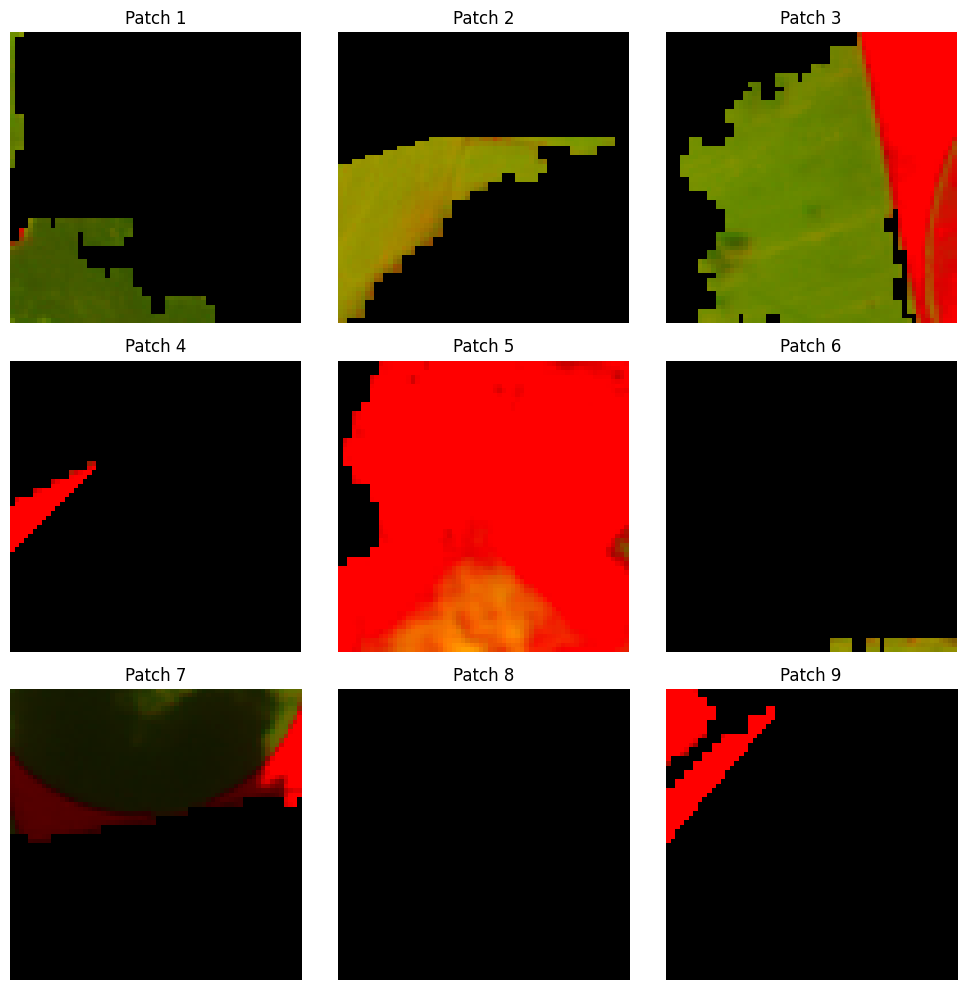

In [9]:


from skimage import color

def adjust_image_for_display(img):
    """
    Ajusta a imagem para melhor visualização de áreas agrícolas
    - Vegetação alta: vermelho
    - Solo exposto: verde
    - Agricultura: alaranjado
    - Pastagem: verde claro
    """
    # Normalizar para [0, 1]
    img_norm = (img - img.min()) / (img.max() - img.min())
    
    # Realçar características específicas
    if len(img_norm.shape) == 3:
        # Assumindo ordem RGB
        r, g, b = img_norm[..., 0], img_norm[..., 1], img_norm[..., 2]
        
        # Calcular índice de vegetação normalizado (NDVI-like)
        veg_index = (r - b) / (r + b + 1e-10)
        
        # Criar imagem realçada
        enhanced = np.zeros_like(img_norm)
        
        # Canal vermelho: realçar vegetação alta
        enhanced[..., 0] = np.clip(r * (1 + veg_index), 0, 1)
        
        # Canal verde: realçar solo exposto
        enhanced[..., 1] = np.clip(g * (1 - veg_index), 0, 1)
        
        # Canal azul: suavizar para dar contraste
        enhanced[..., 2] = b * 0
        
        # Ajustar contraste
        enhanced = np.power(enhanced, 1/1.2)  # gamma correction
        
        # Aumentar saturação
        hsv = color.rgb2hsv(enhanced)
        hsv[..., 1] *= 1.4  # Aumentar saturação
        enhanced = color.hsv2rgb(hsv)
        
        return np.clip(enhanced, 0, 1)
    else:
        return img_norm

def plot_patches(dataset):
    plt.figure(figsize=(10, 10))
    for i, batch in enumerate(dataset.take(1)):
        for j in range(9):
            plt.subplot(3, 3, j+1)
            # Pegar a imagem do batch e converter para numpy
            rgb = batch[j].numpy()
            # Aplicar o ajuste de cores
            rgb_adjusted = adjust_image_for_display(rgb)
            plt.imshow(rgb_adjusted)
            plt.axis('off')
            plt.title(f'Patch {j+1}')
    plt.tight_layout()
    plt.show()

# Plotar os patches com o novo ajuste de cores
plot_patches(train_ds)

## 4. Implementação e Treinamento do Modelo

### 4.1 Arquitetura do Modelo

Nossa CNN é otimizada para detectar:
- Padrões regulares de cultivo agrícola
- Texturas características de florestas
- Diferentes estágios de crescimento
- Áreas de transição agricultura-floresta

In [3]:
# Inicializar o modelo
model = UnsupervisedCNN(
    input_shape=(64, 64, 3),
    n_clusters=5,  # Ajuste baseado nos tipos esperados de cobertura
    latent_dim=128,
    experiment_name='agricultura_floresta_classificacao_2'
)

# Converter dataset para numpy array
X_train = np.concatenate([batch.numpy() for batch in train_ds], axis=0)

# Treinar o modelo
model.train(
    X_train,
    epochs=50,
    batch_size=32,
    learning_rate=0.001,  # Ajuste conforme necessário
    dropout_rate=0.3,     # Ajuste conforme necessário
    use_data_augmentation=True
)

Training will continue but metrics may not be logged


2025-04-04 22:54:09.799520: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 371294208 exceeds 10% of free system memory.
2025-04-04 22:54:10.422313: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Starting new MLflow run
Continuing training without MLflow...


2025-04-04 22:54:11.642560: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 371294208 exceeds 10% of free system memory.
2025-04-04 22:54:12.238258: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 371294208 exceeds 10% of free system memory.


Epoch 1/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6789 - loss: 38.5494 - mae: 2.6575

378/378 ━━━━━━━━━━━━━━━━━━━━ 139s 360ms/step - accuracy: 0.6791 - loss: 38.5449 - mae: 2.6572 - val_accuracy: 0.8536 - val_loss: 99.8076 - val_mae: 6.2587 - learning_rate: 0.0010
Epoch 2/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7945 - loss: 36.5246 - mae: 2.5014

378/378 ━━━━━━━━━━━━━━━━━━━━ 137s 363ms/step - accuracy: 0.7945 - loss: 36.5253 - mae: 2.5014 - val_accuracy: 0.8614 - val_loss: 99.7792 - val_mae: 6.2233 - learning_rate: 0.0010
Epoch 3/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 131s 347ms/step - accuracy: 0.7918 - loss: 34.7796 - mae: 2.3449 - val_accuracy: 0.8671 - val_loss: 107.2284 - val_mae: 6.5314 - learning_rate: 0.0010
Epoch 4/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 79s 209ms/step - accuracy: 0.8014 - loss: 40.1889 - mae: 2.6463 - val_accuracy: 0.8671 - val_loss: 105.4699 - val_mae: 6.5340 - learning_rate: 0.0010
Epoch 5/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 79s 208ms/step - accuracy: 0.7968 - loss: 39.2574 - mae: 2.7185 - val_accuracy: 0.8671 - val_loss: 104.2986 - val_mae: 6.5360 - learning_rate: 0.0010
Epoch 6/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 77s 205ms/step - accuracy: 0.7948 - loss: 39.0051 - mae: 2.7907 - val_accuracy: 0.8671 - val_loss: 103.4381 - val_mae: 6.5377 - learning_rate: 0.0010
Epoch 7/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 78s 207ms/step - acc

## 5. Interpretação dos Resultados

### 5.1 Padrões Esperados

Ao analisar os clusters, procure por:

**Áreas Agrícolas:**
- Padrões geométricos regulares
- Variações de intensidade por estágio de cultivo
- Bordas bem definidas entre talhões

**Áreas Florestais:**
- Textura mais rugosa e irregular
- Alta resposta no NIR (B8)
- Padrão mais homogêneo em grandes áreas

**Transições e Casos Especiais:**
- Áreas de regeneração florestal
- Sistemas agroflorestais
- Agricultura em diferentes estágios

In [4]:
# Fazer predições
predictions = model.predict(X_train)


# Importar módulos necessários
from skimage import color
import numpy as np

237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


/tmp/ipykernel_78817/2376654578.py:14: RuntimeWarning: invalid value encountered in divide
  img_norm = (img - img.min()) / (img.max() - img.min())


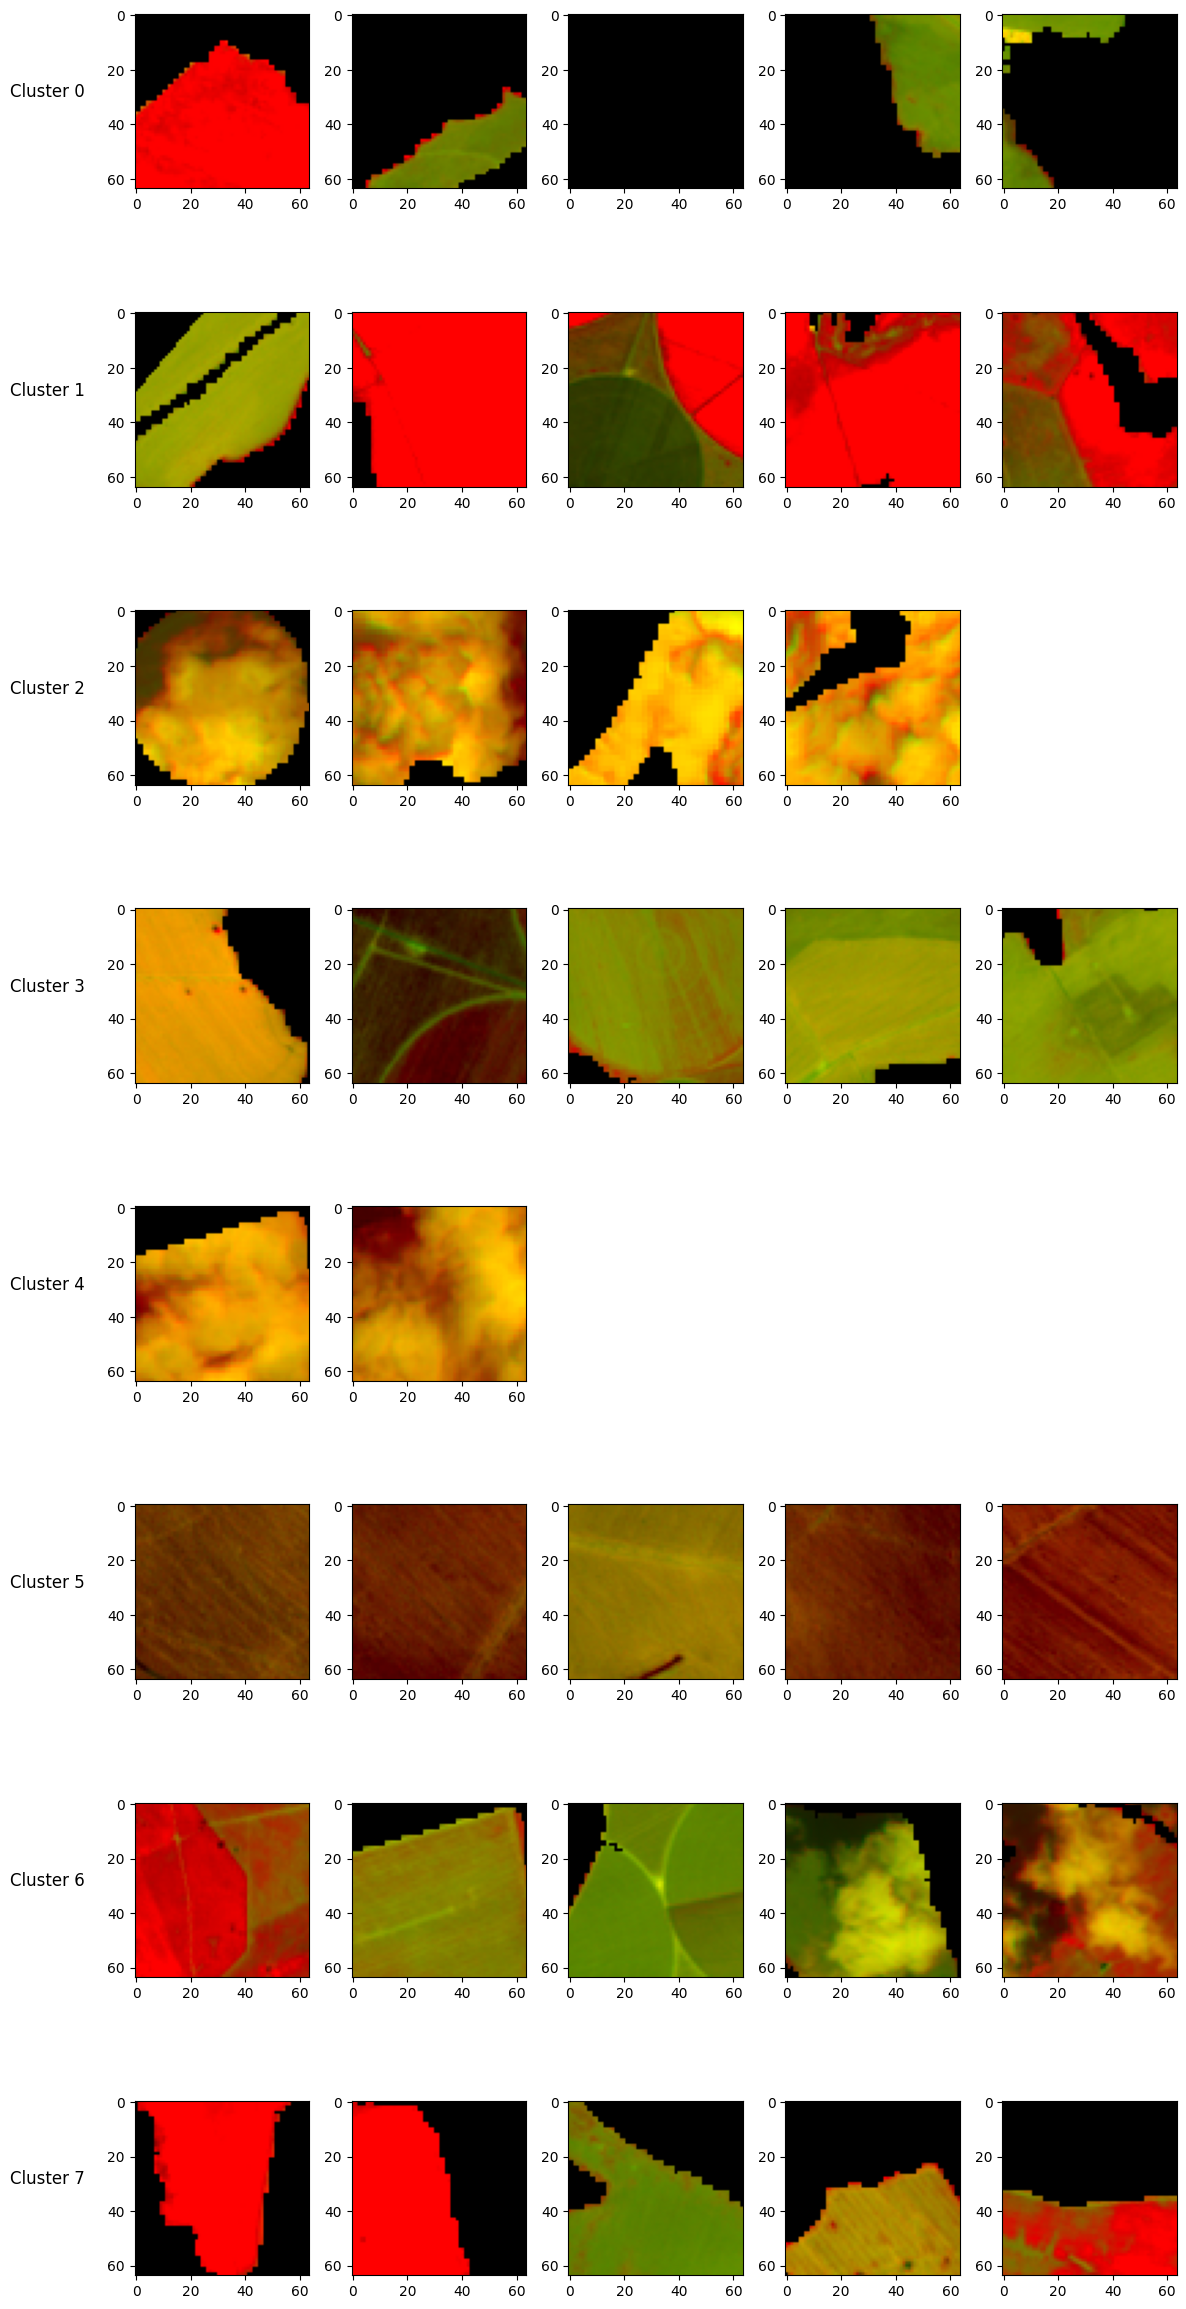

In [5]:


# Criar figura com mais espaço à esquerda
plt.figure(figsize=(15, 3*model.n_clusters))
plt.subplots_adjust(left=0.2)

def adjust_image_for_display(img):
    """
    Ajusta a imagem para melhor visualização de áreas agrícolas
    - Vegetação alta: vermelho
    - Solo exposto: verde
    - Agricultura: alaranjado
    - Pastagem: verde claro
    """
    # Normalizar para [0, 1]
    img_norm = (img - img.min()) / (img.max() - img.min())
    
    # Realçar características específicas
    if len(img_norm.shape) == 3:
        # Assumindo ordem RGB
        r, g, b = img_norm[..., 0], img_norm[..., 1], img_norm[..., 2]
        
        # Calcular índice de vegetação normalizado (NDVI-like)
        veg_index = (r - b) / (r + b + 1e-10)
        
        # Criar imagem realçada
        enhanced = np.zeros_like(img_norm)
        
        # Canal vermelho: realçar vegetação alta
        enhanced[..., 0] = np.clip(r * (1 + veg_index), 0, 1)
        
        # Canal verde: realçar solo exposto
        enhanced[..., 1] = np.clip(g * (1 - veg_index), 0, 1)
        
        # Canal azul: suavizar para dar contraste
        enhanced[..., 2] = b * 0.
        
        # Ajustar contraste
        enhanced = np.power(enhanced, 1/1.2)  # gamma correction
        
        # Aumentar saturação
        hsv = color.rgb2hsv(enhanced)
        hsv[..., 1] *= 1.4  # Aumentar saturação
        enhanced = color.hsv2rgb(hsv)
        
        return np.clip(enhanced, 0, 1)
    else:
        return img_norm

for cluster in range(model.n_clusters):
    cluster_samples = X_train[predictions == cluster][:5]
    for j, sample in enumerate(cluster_samples):
        ax = plt.subplot(model.n_clusters, 5, cluster*5 + j + 1)
        
        # Aplicar ajustes na imagem
        adjusted_sample = adjust_image_for_display(sample)
        
        plt.imshow(adjusted_sample)
        #plt.axis('off')
        if j == 0:
            ax.set_ylabel(f'Cluster {cluster}', fontsize=12, rotation=0)
            ax.yaxis.set_label_coords(-0.5, 0.5)

plt.tight_layout(rect=[0.2, 0, 1, 1])
plt.show()

## 6. Categorização dos Clusters

Vamos categorizar os clusters com foco em agricultura e floresta:

In [ ]:
from src.models.cluster_categorizer import ClusterCategorizer

categorizer = ClusterCategorizer(n_clusters=model.n_clusters)

# Exemplo de categorias específicas para agricultura e floresta
categorias_exemplo = [
    ('floresta_densa', 'Floresta madura com dossel fechado'),
    ('agricultura_estabelecida', 'Culturas em estágio avançado'),
    ('agricultura_inicial', 'Áreas recém plantadas ou em preparo'),
    ('floresta_regeneracao', 'Áreas em processo de regeneração florestal'),
    ('agroflorestal', 'Sistemas que combinam agricultura e floresta')
]

# Categorizar clusters
for i, (categoria, descricao) in enumerate(categorias_exemplo):
    if i < model.n_clusters:
        categorizer.categorize_cluster(
            cluster_id=i,
            category=categoria,
            description=descricao,
            confidence=0.8
        )

# Visualizar resultados
categorizer.plot_cluster_samples(X_train, predictions)

## 7. Dicas para Interpretação

### 7.1 Características Espectrais

**Floresta:**
- Alta reflectância no NIR (B8)
- Baixa reflectância no vermelho (B4)
- Valores intermediários no SWIR (B11)

**Agricultura:**
- Variação sazonal na reflectância
- Padrões distintos por tipo de cultura
- Resposta espectral varia com estágio de crescimento

### 7.2 Padrões Espaciais

**Floresta:**
- Textura rugosa
- Bordas naturais irregulares
- Variação gradual de densidade

**Agricultura:**
- Formas geométricas regulares
- Bordas bem definidas
- Padrões de plantio visíveis

### 7.3 Validação

Para validar suas interpretações:
1. Compare com mapas de uso do solo existentes
2. Verifique histórico da área
3. Use conhecimento local quando possível
4. Considere a sazonalidade agrícola da região

In [8]:
import geopandas as gpd

gdf = gpd.read_file('/home/luisantolin/Downloads/GO_SOJA_2021/GO_SOJA_2021.shp',driver = 'ESRI')

/home/luisantolin/code/agri_remote_classification/.rmt/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DRIVER
  return ogr_read(


In [31]:
gdf

,ID,SIGLA_UF,CD_MUN,NM_MUN,AREA_HA,geometry
0,1,GO,5221007,Taquaral de Goiás,2.828048,"MULTIPOLYGON (((-49.60268 -15.97977, -49.60245..."
1,2,GO,5221007,Taquaral de Goiás,9.903077,"POLYGON ((-49.53885 -15.97744, -49.53885 -15.9..."
2,3,GO,5221007,Taquaral de Goiás,76.504777,"POLYGON ((-49.54802 -15.99953, -49.54802 -15.9..."
3,4,GO,5221007,Taquaral de Goiás,7.034757,"POLYGON ((-49.58898 -15.9972, -49.58898 -15.99..."
4,5,GO,5221007,Taquaral de Goiás,15.789888,"POLYGON ((-49.53652 -15.99792, -49.53652 -15.9..."
...,...,...,...,...,...,...
27026,27027,GO,5211800,Jaraguá,6.655168,"POLYGON ((-49.4307 -15.91294, -49.4307 -15.913..."
27027,27028,GO,5212055,Jesúpolis,7.152387,"POLYGON ((-49.38524 -15.91258, -49.38524 -15.9..."
27028,27029,GO,5211800,Jaraguá,5.698852,"POLYGON ((-49.43411 -15.91725, -49.43411 -15.9..."
27029,27030,GO,5211800,Jaraguá,24.767105,"POLYGON ((-49.4316 -15.91976, -49.4316 -15.919..."
